In [24]:
import os
import logging
import logging.handlers
import random

import numpy as np
import skvideo.io
import cv2
import matplotlib.pyplot as plt

import utils

import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
from pipeline import (
    PipelineRunner,
    ContourDetection,
    Visualizer,
    CsvWriter,
    VehicleCounter)

In [26]:
cv2.ocl.setUseOpenCL(False)
random.seed(123)

In [27]:
IMAGE_DIR = "./out"
VIDEO_SOURCE = "input.mp4"
SHAPE = (720, 1280)  # HxW
EXIT_PTS = np.array([[[732, 720], [732, 590], [1280, 500], [1280, 720]], [[0, 400], [645, 400], [645, 0], [0, 0]]])

In [28]:
def train_bg_subtractor(inst, cap, num=500):
    '''
        BG substractor need process some amount of frames to start giving result
    '''
    print ('Training BG Subtractor...')
    i = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if not ret:
            break
        inst.apply(frame, None, 0.001)
        i += 1
        if i >= num:
            return cap

In [ ]:
if not os.path.exists(IMAGE_DIR):
    log.debug("Creating image directory `%s`...", IMAGE_DIR)
    os.makedirs(IMAGE_DIR)

# creting MOG bg subtractor with 500 frames in cache
# and shadow detction
bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=500, detectShadows=True)

# Set up image source
cap = cv2.VideoCapture('video/short.mp4')

# skipping 500 frames to train bg subtractor
train_bg_subtractor(bg_subtractor, cap, num=500)

frame_number = -1
while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    if not frame.any():
        log.error("Frame capture failed, stopping...")
        break

    frame_number += 1

    utils.save_frame(frame, "./out/frame_%04d.png" % frame_number)

    fg_mask = bg_subtractor.apply(frame, None, 0.001)

    utils.save_frame(fg_mask, "./out/fg_mask_%04d.png" % frame_number)


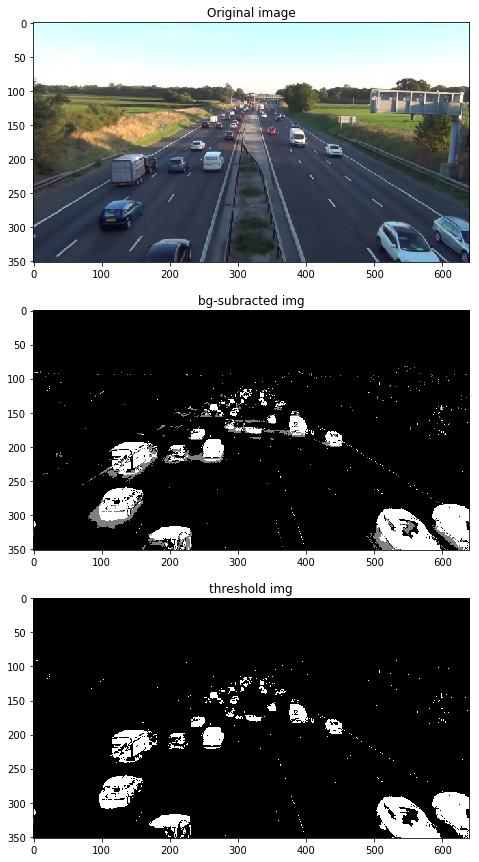

In [29]:
img = cv2.imread("examples/frame_0000.png")
fg_mask = cv2.imread("examples/fg_mask_0000.png",0)
ret,thresh4 = cv2.threshold(fg_mask,127,255,cv2.THRESH_TOZERO)

new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

f, axs = plt.subplots(3,figsize=(15,15))

axs[0].imshow(new_img)
axs[0].set_title('Original image')
axs[1].imshow(fg_mask,'gray')
axs[1].set_title('bg-subracted img')
axs[2].imshow(thresh4,'gray')
axs[2].set_title('threshold img')
plt.show()